## Baysian - Diffrence in Diffrence - Model 2

In [2]:
import sys
print(sys.version)


import numpy

# Import necessary package 
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf

from scipy import optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import aesara


import arviz as az

import tensorflow as tf
import altair as alt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
import sys

import datetime as dt
#imcport pandas_datareader.data as web


# For model fit
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm

# for reproducable results
import random
#import theano
import pymc as pm  # Assuming you're using the latest PyMC version


3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]


/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_38536/795410520.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
SEED = 5
np.random.seed(SEED)

# 0. Reading-in Set that has missings
water_baysian = pd.read_csv('water_baysian.csv')

# 1. Transforming

In [4]:
# filter for border context
water_baysian = water_baysian.loc[water_baysian['match_rpf_sa']== True]

water_baysian['log_gdp'] = np.log(water_baysian['gdp'])
water_baysian['log_mean_precip'] = np.log(water_baysian['mean_precip'])
water_baysian['log_pop_density'] = np.log(water_baysian['pop_density'])
water_baysian['log_fremdbezug_perfirm'] = np.log(water_baysian['fremdbezug']/water_baysian['n_betriebe_eg'])
water_baysian['log_perc_gruene'] = np.log(water_baysian['perc_gruene'])
water_baysian['log_sw_area'] = np.log(water_baysian['sw_area'])


# convert to float 32 and round to 3 for staorage saving
water_baysian['log_gdp'] =water_baysian['log_gdp'].round(3).astype('float32')
water_baysian['log_mean_precip'] =water_baysian['log_mean_precip'].round(3).astype('float32')
water_baysian['log_pop_density'] =water_baysian['log_pop_density'].round(3).astype('float32')
water_baysian['log_fremdbezug_perfirm'] = water_baysian['log_fremdbezug_perfirm'].round(3).astype('float32')
water_baysian['log_perc_gruene'] = water_baysian['log_perc_gruene'].round(3).astype('float32')
water_baysian['log_sw_area'] = water_baysian['log_sw_area'].round(3).astype('float32')


In [5]:

# Post and post treated indicator
water_baysian['post'] = (water_baysian['year']>=2013).astype('Int32')
water_baysian['treat_post']= water_baysian['post']* water_baysian['treated_b']  
post = np.array(water_baysian['post'])

# 2. Standardidtypes Data
We are dealing with the nas in the Dataset by masking them at this point and and standardize them according to the process implemented in the Lecture. The masked arrays are just used when we turn to the Baysian Regression.

In [6]:
def standardize_ma(x):
    x_ma = np.ma.masked_invalid(x)
    return (x_ma-x_ma.mean())/x_ma.std()

In [7]:
# Standardize the y variable
log_grund_perfirm = standardize_ma((water_baysian['log_grund_perfirm']))
# Standardize MA the explanatory variables

log_gdp = standardize_ma(water_baysian['log_gdp'])
log_mean_precip = standardize_ma(water_baysian['log_mean_precip'])
log_pop_density = standardize_ma(water_baysian['log_pop_density'])
log_fremdbezug_perfirm = standardize_ma(water_baysian['log_fremdbezug_perfirm'])
log_perc_gruene = standardize_ma(water_baysian['log_perc_gruene'])
log_sw_area = standardize_ma(water_baysian['log_sw_area'])

In [8]:
# convert to arrays
log_grund_perfirm = np.array(log_grund_perfirm)
log_gdp= np.array(log_gdp)
log_mean_precip= np.array(log_mean_precip)
log_pop_density = np.array(log_pop_density)
log_fremdbezug_perfirm = np.array(log_fremdbezug_perfirm)
log_perc_gruene = np.array(log_perc_gruene)
log_sw_area = np.array(log_sw_area)

# Vinc model mit Covariates

In [9]:
# model für a und b
def outcome_cov(t, control_intercept, treat_intercept_delta, trend, d, group, treated,b_log_gdp , Log_gdp , b_log_mean_precip ,Log_mean_precip , b_log_pop_density ,Log_pop_density , b_log_fremdbezug_perfirm , Log_mean_fremdbezug_perfirm ,
         b_log_sw_area,Log_sw_area):
    return control_intercept + (treat_intercept_delta * group) + (t * trend) + (d * treated * group) + (b_log_gdp * Log_gdp) + (b_log_mean_precip * Log_mean_precip) + (b_log_pop_density * Log_pop_density) + (b_log_fremdbezug_perfirm * Log_mean_fremdbezug_perfirm) + (b_log_sw_area * Log_sw_area)


with pm.Model() as bm_vinc_full:
    # data
    t = pm.MutableData("t", water_baysian["post"].values, dims="obs_idx")
    treated = pm.MutableData("treated", water_baysian["treat_post"].values, dims="obs_idx")
    group = pm.MutableData("group", water_baysian["treated_b"].values, dims="obs_idx")
    σ_prior = 0.1
    # Covariates
    b_log_gdp = pm.Normal('b_log_gdp', mu=0.0, sigma=σ_prior)
    b_log_mean_precip = pm.Normal('b_log_mean_precip', mu=0.0, sigma=σ_prior)
    b_log_pop_density = pm.Normal('b_log_pop_density', mu=0.0, sigma=σ_prior)
    b_log_fremdbezug_perfirm = pm.Normal('b_log_fremdbezug_perfirm', mu=0.0, sigma=σ_prior)
    b_log_sw_area = pm.Normal('b_log_sw_area', mu=0.0, sigma=σ_prior)
    
    # Observations
    Log_gdp = pm.Normal('Log_gdp', mu=0, sigma=1.0, observed=log_gdp)
    Log_pop_density = pm.Normal('Log_pop_density', mu=0, sigma=1.0, observed=log_pop_density)
    Log_mean_precip = pm.Normal('Log_mean_precip', mu=0, sigma=1.0, observed=log_mean_precip)
    Log_mean_fremdbezug_perfirm = pm.Normal('Log_mean_fremdbezug_perfirm', mu=0, sigma=1.0, observed=log_fremdbezug_perfirm)
    Log_sw_area = pm.Normal('Log_sw_area', mu=0, sigma=2.0, observed=log_sw_area)
    
    
    # Priors
    _control_intercept = pm.Normal("control_intercept", 0, 1)
    _treat_intercept_delta = pm.Normal("treat_intercept_delta", 0, 1)
    _trend = pm.Normal("trend", 0, 1)
    _d = pm.Normal("d", 0, 1)
    sigma = pm.HalfNormal("sigma", 1)
    
    # expectation
    mu = pm.Deterministic(
        "mu",
        outcome_cov(t, _control_intercept, _treat_intercept_delta, _trend, _d, group, treated,b_log_gdp , Log_gdp , b_log_mean_precip ,Log_mean_precip , b_log_pop_density ,Log_pop_density , b_log_fremdbezug_perfirm , Log_mean_fremdbezug_perfirm ,
         b_log_sw_area,Log_sw_area),
        dims="obs_idx",
    )
    # likelihood
    pm.Normal("obs", mu, sigma, observed=log_grund_perfirm, dims="obs_idx")

/opt/conda/lib/python3.9/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in Log_mean_precip contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/opt/conda/lib/python3.9/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in Log_mean_fremdbezug_perfirm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/opt/conda/lib/python3.9/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [10]:
with bm_vinc_full:
    idata_full = pm.sample(return_inferencedata = True)
idata_full.to_netcdf('bays_full_vinc_did_trace.nc')

/opt/conda/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_log_gdp, b_lo

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.


'bays_full_vinc_did_trace.nc'

In [11]:
trace = idata_full.posterior 
trace

<xarray.Dataset>
Dimensions:                                       (chain: 4, draw: 1000,
                                                   Log_mean_precip_unobserved_dim_0: 39,
                                                   Log_mean_fremdbezug_perfirm_unobserved_dim_0: 6,
                                                   obs_unobserved_dim_0: 20,
                                                   Log_mean_precip_dim_0: 225,
                                                   Log_mean_fremdbezug_perfirm_dim_0: 225,
                                                   obs_idx: 225)
Coordinates:
  * chain                                         (chain) int64 0 1 2 3
  * draw                                          (draw) int64 0 1 2 ... 998 999
  * Log_mean_precip_unobserved_dim_0              (Log_mean_precip_unobserved_dim_0) int64 ...
  * Log_mean_fremdbezug_perfirm_unobserved_dim_0  (Log_mean_fremdbezug_perfirm_unobserved_dim_0) int64 ...
  * obs_unobserved_dim_0                          (obs_unobserved_dim_0) int64 ...
  * Log_mean_precip_dim_0                         (Log_mean_precip_dim_0) int64 ...
  * Log_mean_fremdbezug_perfirm_dim_0             (Log_mean_fremdbezug_perfirm_dim_0) int64 ...
  * obs_idx                                       (obs_idx) int64 0 1 ... 224
Data variables: (12/17)
    b_log_gdp                                     (chain, draw) float64 -0.05...
    b_log_mean_precip                             (chain, draw) float64 -0.05...
    b_log_pop_density                             (chain, draw) float64 0.218...
    b_log_fremdbezug_perfirm                      (chain, draw) float64 0.200...
    b_log_sw_area                                 (chain, draw) float64 0.127...
    Log_mean_precip_unobserved                    (chain, draw, Log_mean_precip_unobserved_dim_0) float64 ...
    ...                                            ...
    obs_unobserved                                (chain, draw, obs_unobserved_dim_0) float64 ...
    sigma                                         (chain, draw) float64 0.920...
    Log_mean_precip                               (chain, draw, Log_mean_precip_dim_0) float64 ...
    Log_mean_fremdbezug_perfirm                   (chain, draw, Log_mean_fremdbezug_perfirm_dim_0) float64 ...
    mu                                            (chain, draw, obs_idx) float64 ...
    obs                                           (chain, draw, obs_idx) float64 ...
Attributes:
    created_at:                 2024-02-09T15:07:37.966467
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              205.19921827316284
    tuning_steps:               1000

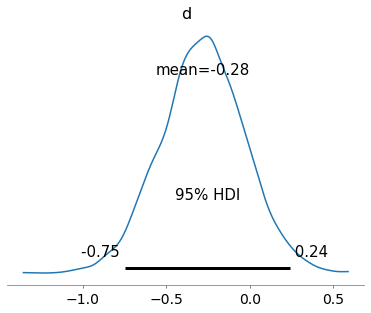

In [12]:
az.plot_posterior(trace, var_names =["d"], hdi_prob = 0.95);

In [13]:
idata_full.to_netcdf('bays_full_vinc_did_trace.nc')

'bays_full_vinc_did_trace.nc'

In [14]:
variables_ofinterest = ['control_intercept', 'd','trend', 'treat_intercept_delta','b_log_gdp', 'b_log_mean_precip', 'b_log_pop_density','b_log_fremdbezug_perfirm', 'b_log_sw_area' ]
summary_pm = pm.summary(idata_full, var_names=variables_ofinterest)

summary_pm.columns

Index(['mean', 'sd', 'hdi_3%', 'hdi_97%', 'mcse_mean', 'mcse_sd', 'ess_bulk',
       'ess_tail', 'r_hat'],
      dtype='object')

In [15]:
selected_summary_df = summary_pm[['mean', 'sd','hdi_3%','hdi_97%', 'r_hat']]

formatted_df= selected_summary_df.applymap(lambda x : f'{x:.3f}')

formatted_df.reset_index(inplace= True)
formatted_df.rename(columns= {'index':'Variable', 'mean':'Mean', 'sd':'SD'}, inplace = True)
formatted_df.to_csv('baysian_fee_summary.csv', index=False)
formatted_df

/tmp/ipykernel_38536/3498002226.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df= selected_summary_df.applymap(lambda x : f'{x:.3f}')


,Variable,Mean,SD,hdi_3%,hdi_97%,r_hat
0,control_intercept,-0.001,0.140,-0.260,0.262,1.000
1,d,-0.283,0.252,-0.739,0.207,1.000
2,trend,-0.153,0.179,-0.463,0.192,1.000
3,treat_intercept_delta,0.420,0.198,0.068,0.820,1.000
4,b_log_gdp,0.069,0.065,-0.054,0.190,1.000
5,b_log_mean_precip,-0.059,0.061,-0.186,0.048,1.000
6,b_log_pop_density,0.183,0.073,0.047,0.321,1.000
7,b_log_fremdbezug_perfirm,0.170,0.061,0.054,0.284,1.000
8,b_log_sw_area,0.131,0.064,0.004,0.243,1.000


<Figure size 864x1296 with 0 Axes>

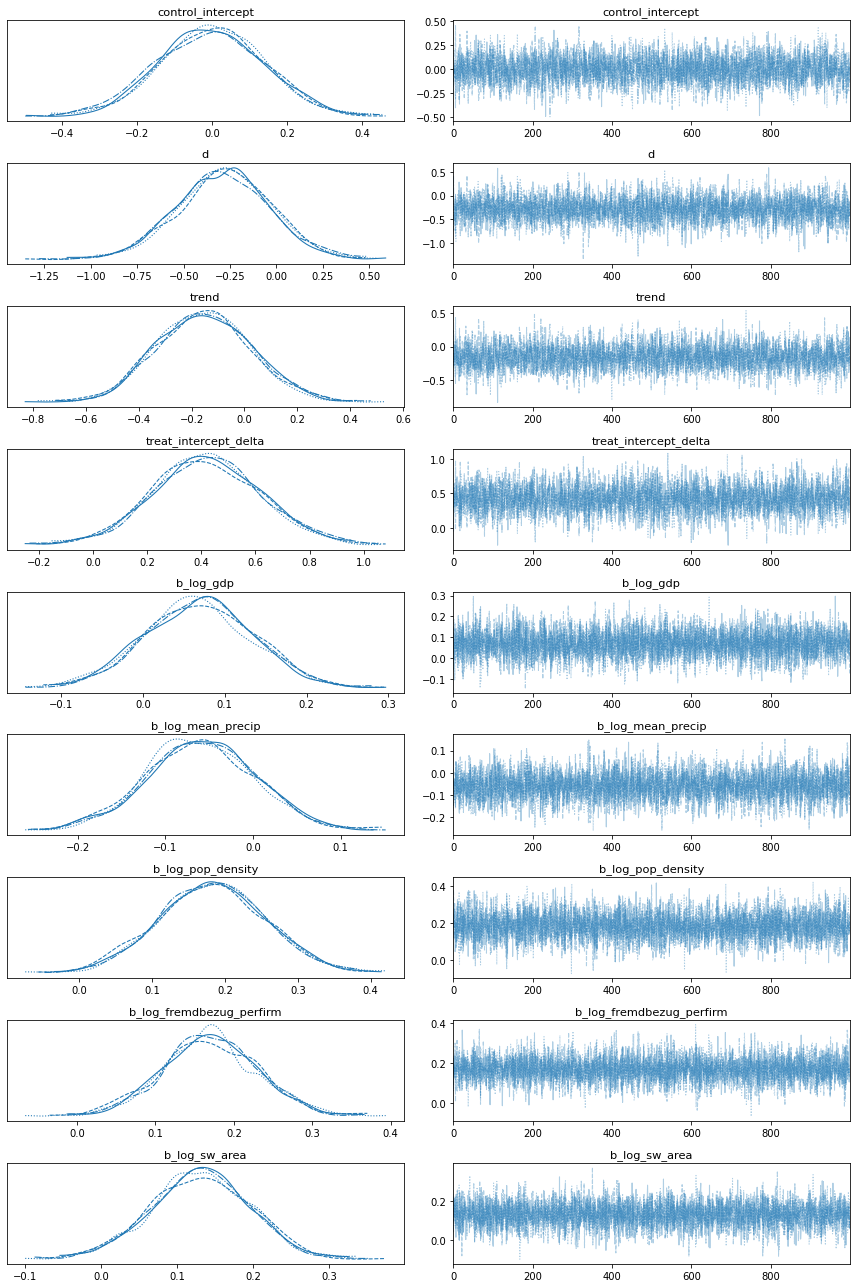

In [16]:
plt.figure(figsize = (12, len(variables_ofinterest)*2 ))
az.plot_trace(trace, var_names = variables_ofinterest,compact=True);
plt.tight_layout()
plt.savefig('Bayes_trace_plot.png', dpi=300) 

In [17]:
latex_pm_table= formatted_df.to_latex(index = False, caption = 'Summary Baysian - DiD', label = 'table:baysian_did_model',longtable = False,escape = False)

with open('bayes_did_summary_table.tex','w') as f:
    f.write(latex_pm_table)

In [18]:
with bm_vinc_full:
    ppc_full= pm.sample_posterior_predictive(idata_full)
    
    
ppc_full

Sampling: [Log_gdp, Log_mean_fremdbezug_perfirm_observed, Log_mean_precip_observed, Log_pop_density, Log_sw_area, obs_observed, obs_unobserved]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [19]:
percentiles = np.percentile(ppc_full.posterior_predictive['obs'],[2.5,97.5],axis=[0]).T
percentiles= percentiles.reshape(225,-1)
percentiles

array([[-0.35761566,  1.49305578, -0.81969908, ...,  0.08842194,
        -1.96588773,  0.02113536],
       [-2.1136372 , -0.0216308 , -1.42129076, ...,  1.34169795,
        -1.37026559,  0.87253927],
       [-0.89019394,  1.2019336 , -1.39578184, ...,  0.23819921,
        -1.2390675 ,  0.72746584],
       ...,
       [-0.4278907 ,  1.0370913 , -1.56542331, ...,  1.79219738,
        -0.73411735,  0.99919709],
       [-0.76869373,  0.10216893, -0.92356724, ...,  1.13537567,
         0.03304913,  1.28643357],
       [-0.90644627,  1.36103871, -0.61338336, ...,  0.71002842,
        -1.645142  ,  0.04402308]])

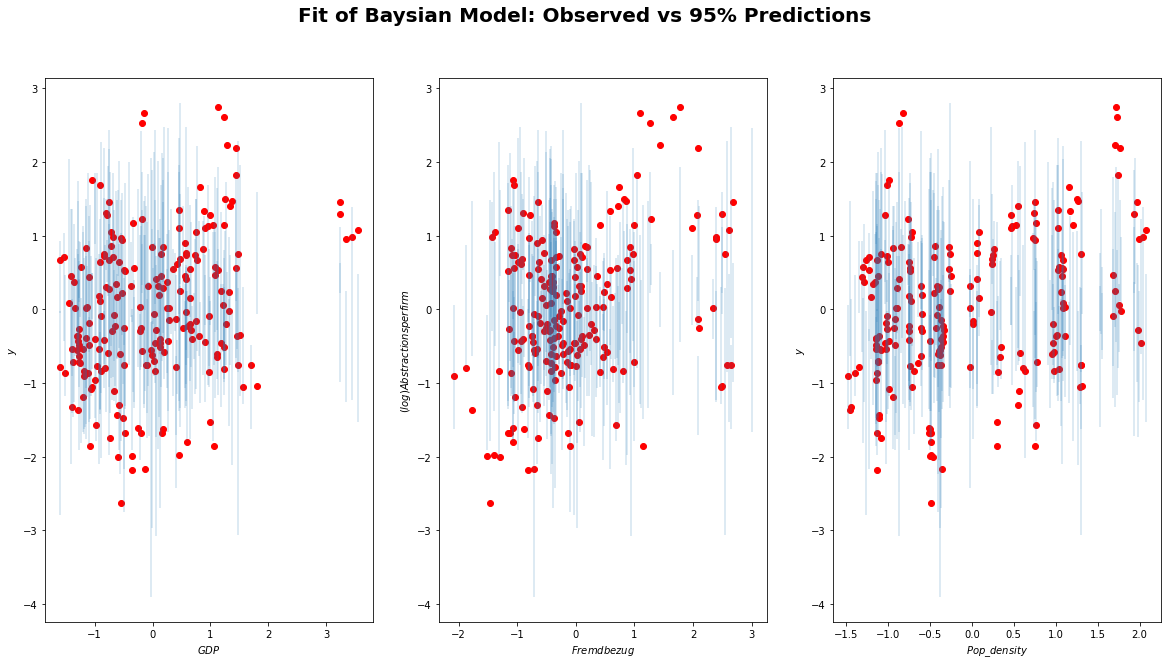

In [21]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle('Fit of Baysian Model: Observed vs 95% Predictions',fontsize=20, fontweight='bold' )


ax1.vlines(log_gdp,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(log_gdp,log_grund_perfirm, color='r')
ax1.set(xlabel='$GDP$', ylabel='$y$');

ax2.vlines(log_fremdbezug_perfirm,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(log_fremdbezug_perfirm,log_grund_perfirm, color='r')
ax2.set(xlabel='$Fremdbezug$', ylabel='$y$');
ax2.set_ylabel('$(log) Abstractions per firm$')

ax3.vlines(log_pop_density,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax3.scatter(log_pop_density,log_grund_perfirm, color='r')
ax3.set(xlabel='$Pop\_density$', ylabel='$y$');

plt.savefig('modelfit_bay_vincent.pdf')